In [1]:
# Draw 2D bounding box on image 
import cv2
import time
import os
import sys
sys.path.insert(0, "../kitti/")
from util_kitti import init_img_plt, draw_2Dbox, kitti_label_file_parser, draw_corner_2D, draw_birdeyes, kitti_calib_file_parser
from util_kitti import AVG_LENTH, KITTI_Object, compute_birdviewbox, load_tf_image
import random 
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import numpy as np
import math
from noam import noam_encode
import matplotlib.patches as patches

# random.seed(2222)
NUM_IMAGE_SHOW = 10 # 20

# images files 
IMG_DIR = "/home/lab530/KenYu/kitti/training/image_2/"
# Anotations files 
ANO_DIR = "/home/lab530/KenYu/kitti/training/label_2/"
# Prediction files
PRD_DIR = "/home/lab530/KenYu/pytorch-retinanet/checkpoint/2D_detection_3/result/"
# 
CAR_DIR = "/home/lab530/KenYu/kitti/training/calib/"

jit_bev = 4 # For visualization
jit_bev_dict = {"farer": ( jit_bev, 0),
                "close": (-jit_bev, 0),
                "right": (0,  jit_bev),
                "lefft": (0, -jit_bev)}

jit_img = 5 # For visualization
jit_img_dict = {"farer": (jit_img,  0),
                "close": (-jit_img, 0),
                "right": (0,  jit_img),
                "lefft": (0, -jit_img)}


/home/lab530/anaconda3/envs/KenYuGAC/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


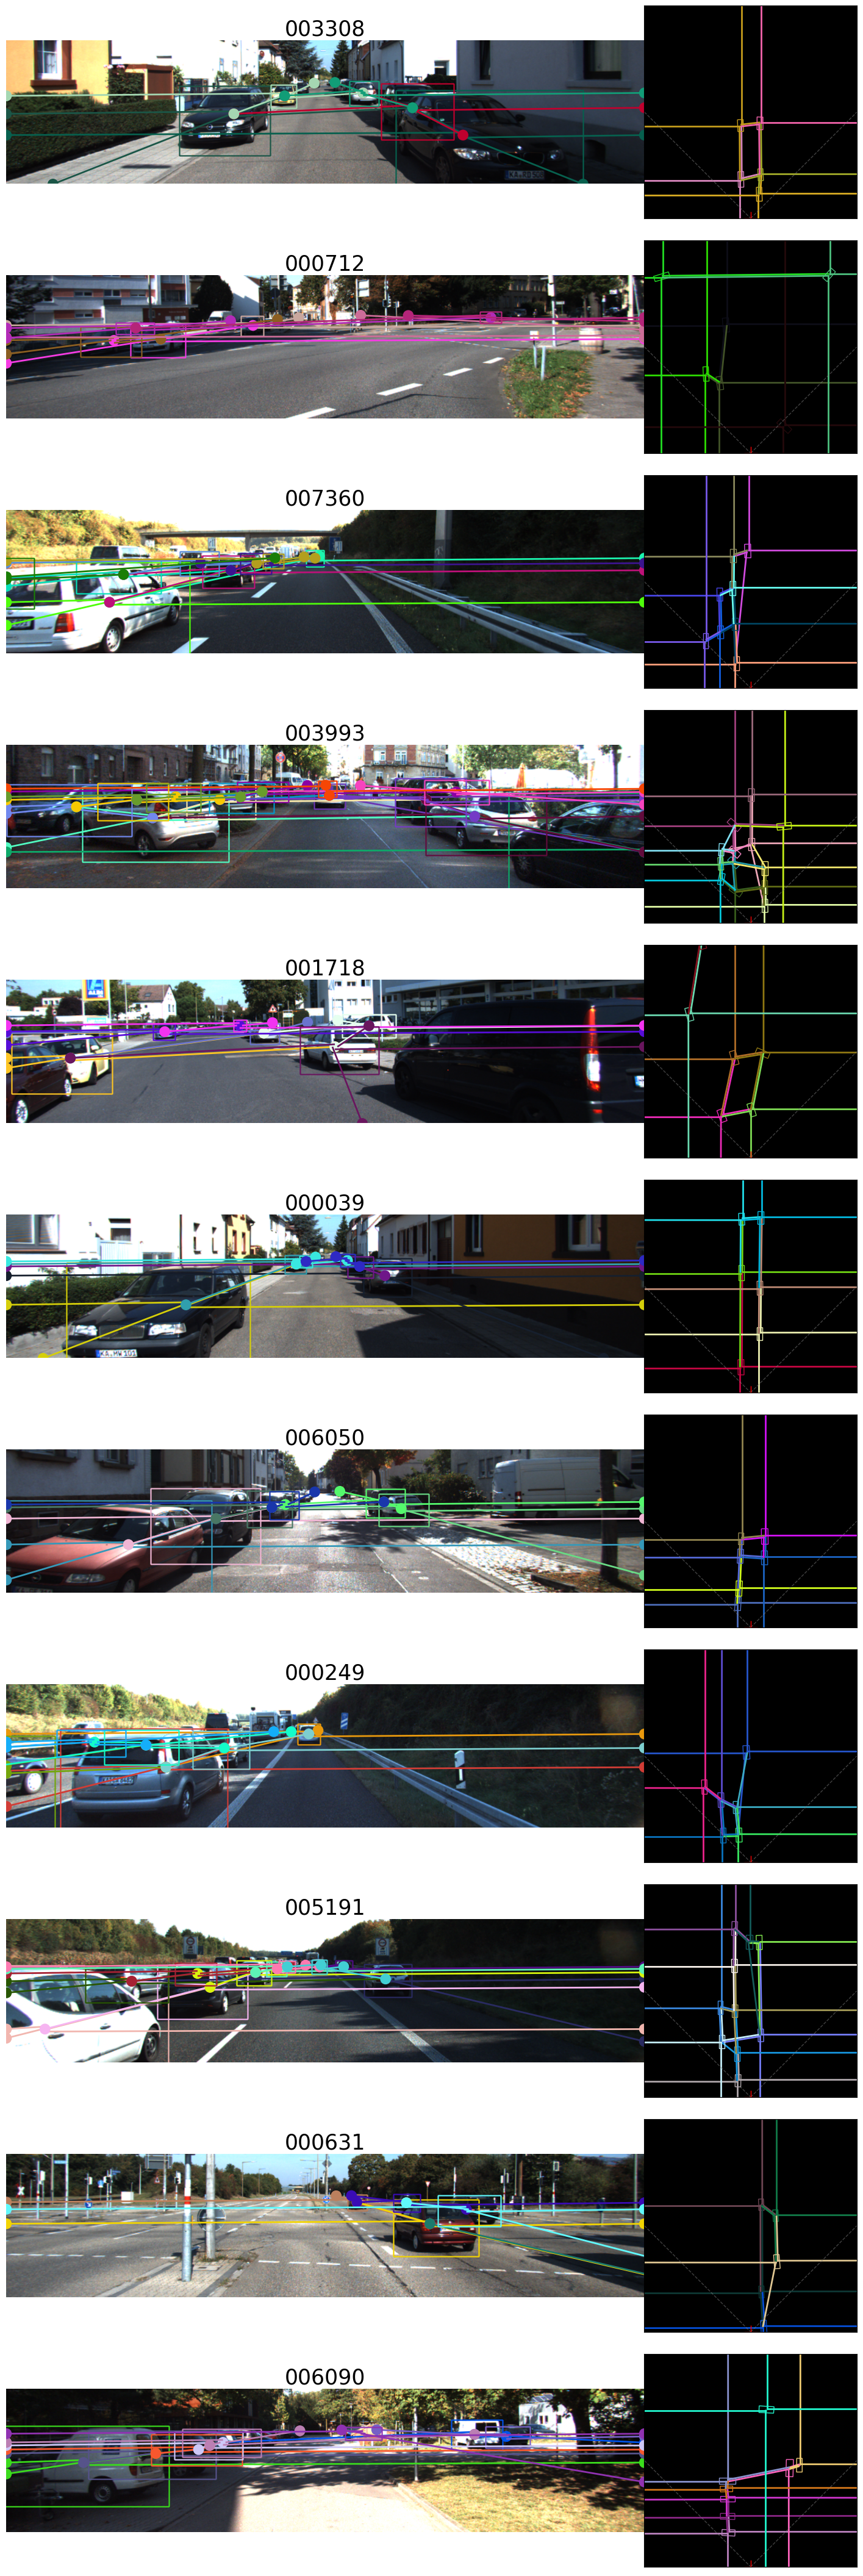

In [2]:

# random.seed(123)
img_names = [i.split('.')[0] for i in os.listdir(ANO_DIR)]

random.shuffle(img_names)

chose_name = img_names[:NUM_IMAGE_SHOW]

chose_name = ['003308', '000712', '007360', '003993', '001718', '000039', '006050', '000249', '005191', '000631', '006090']
# chose_name = ['003308']

# Transform image 
chose_img = []
chose_P2  = []
for name in chose_name:
    P2 = kitti_calib_file_parser(os.path.join(CAR_DIR, f"{name}.txt"), new_shape_tf = (288, 1280), crop_tf = 100)
    img = load_tf_image(os.path.join(IMG_DIR, f"{name}.png"))
    
    chose_P2.append(P2)
    chose_img.append(img)

axs = init_img_plt(chose_img, titles = chose_name)

for i, img_name in enumerate(chose_name):
    
    objs = kitti_label_file_parser(os.path.join(ANO_DIR, f"{img_name}.txt"), tf_matrix = chose_P2[i])

    # Transform 2D bbox via P2 projection
    [obj.transform_2d_bbox() for obj in objs]
    # Filter objs that is not belong to "Car"
    objs = [obj for obj in objs if obj.category == "Car"]
    
    
    noam_target = []
    # Draw annotation on image
    for obj_i in objs:
        
        # 'category, truncated, occluded alpha, xmin, ymin, xmax, ymax, height, width, length, x3d, y3d, z3d, rot_y, score]
        obj_adj = {"farer": KITTI_Object(f"Inf NA NA NA NA NA NA NA {obj_i.h} {obj_i.w} {obj_i.l} {obj_i.x3d} {obj_i.y3d} {100} 1000 NA", chose_P2[i]), 
                   "close": KITTI_Object(f"Inf NA NA NA NA NA NA NA {obj_i.h} {obj_i.w} {obj_i.l} {obj_i.x3d} {obj_i.y3d}   {0} 1000 NA", chose_P2[i]), 
                   "right": KITTI_Object(f"Inf NA NA NA NA NA NA NA {obj_i.h} {obj_i.w} {obj_i.l} { 40} {obj_i.y3d} {obj_i.z3d} 1000 NA", chose_P2[i]), 
                   "lefft": KITTI_Object(f"Inf NA NA NA NA NA NA NA {obj_i.h} {obj_i.w} {obj_i.l} {-40} {obj_i.y3d} {obj_i.z3d} 1000 NA", chose_P2[i])}

        # Find Nearby Object with strick critiron
        for obj_j in objs:
            # Ignore yourself
            if obj_i == obj_j: continue
            
            # Find far and close object       
            if abs(obj_i.x3d - obj_j.x3d) < AVG_LENTH/2:
                z3d_diff = obj_i.z3d - obj_j.z3d
                if   z3d_diff > 0 and abs(z3d_diff) < abs(obj_i.z3d - obj_adj["close"].z3d):
                    obj_adj["close"] = obj_j
                elif z3d_diff < 0 and abs(z3d_diff) < abs(obj_i.z3d - obj_adj["farer"].z3d):
                    obj_adj["farer"] = obj_j

            # Find right and left object   
            elif abs(obj_i.z3d - obj_j.z3d) < AVG_LENTH/2:
                x3d_diff = obj_i.x3d - obj_j.x3d
                if   x3d_diff < 0 and abs(x3d_diff) < abs(obj_i.x3d - obj_adj["right"].x3d):
                    obj_adj["right"] = obj_j
                elif x3d_diff > 0 and abs(x3d_diff) < abs(obj_i.x3d - obj_adj["lefft"].x3d):
                    obj_adj["lefft"]  = obj_j
        
        
        # Find Nearby Object with softer critiron
        for obj_j in objs:
            # Ignore yourself
            if obj_i == obj_j: continue
            
            # Find far and close object
            if abs(obj_i.x3d - obj_j.x3d) < AVG_LENTH:
                z3d_diff = obj_i.z3d - obj_j.z3d
                if   z3d_diff > 0 and abs(z3d_diff) < abs(obj_i.z3d - obj_adj["close"].z3d) and obj_adj["close"].category == 'Inf':
                    obj_adj["close"] = obj_j
                elif z3d_diff < 0 and abs(z3d_diff) < abs(obj_i.z3d - obj_adj["farer"].z3d) and obj_adj["farer"].category == 'Inf':
                    obj_adj["farer"]   = obj_j

            # Find right and left object   
            elif abs(obj_i.z3d - obj_j.z3d) < AVG_LENTH:
                x3d_diff = obj_i.x3d - obj_j.x3d
                if   x3d_diff < 0 and abs(x3d_diff) < abs(obj_i.x3d - obj_adj["right"].x3d) and obj_adj["right"].category == 'Inf':
                    obj_adj["right"] = obj_j
                elif x3d_diff > 0 and abs(x3d_diff) < abs(obj_i.x3d - obj_adj["lefft"].x3d) and obj_adj["lefft"].category == 'Inf':
                    obj_adj["lefft"]  = obj_j
        
        color = [random.random() for _ in range(3)]
        
        # Draw line
        for n in obj_adj:
            
            # if obj_adj[n].category == 'Inf': continue # TODO, whether to draw inf line or not
            
            # Draw line on image
            # path = Path(np.array([(obj_i.cx + jit_img_dict[n][0], obj_i.cy + jit_img_dict[n][1]), 
            #                       (obj_adj[n].cx,             obj_adj[n].cy)], float), 
            #             [Path.MOVETO, Path.LINETO])
            # pathpatch = PathPatch(path, fill=False, color=color, linewidth=2)
            # axs[i][0].add_patch(pathpatch)
            
            # Draw line on BEV image 
            bev_coners_i = compute_birdviewbox(obj_i)
            bev_xi = (bev_coners_i[0, 0] + bev_coners_i[2, 0] ) /2 + jit_bev_dict[n][0]
            bev_yi = (bev_coners_i[0, 1] + bev_coners_i[2, 1] ) /2 + jit_bev_dict[n][1]
            
            bev_coners_j = compute_birdviewbox(obj_adj[n])
            bev_xj = (bev_coners_j[0, 0] + bev_coners_j[2, 0] ) /2 + jit_bev_dict[n][0]
            bev_yj = (bev_coners_j[0, 1] + bev_coners_j[2, 1] ) /2 + jit_bev_dict[n][1]
            
            path = Path(np.array([(bev_xi, bev_yi), (bev_xj, bev_yj)], float), [Path.MOVETO, Path.LINETO])
            pathpatch = PathPatch(path, fill=False, color=color, linewidth=2)
            axs[i][1].add_patch(pathpatch)
            
        # Draw bbox
        # draw_2Dbox(axs[i][0], (obj_i.xmin, obj_i.ymin, obj_i.xmax, obj_i.ymax), color = color)
        draw_birdeyes(axs[i][1], obj_i, color = color, title = "123", is_print_confident = False)
        # draw_corner_2D(axs[i][0], obj_i.corner_2D, color = color, is_draw_front = True)
        
        ###############################
        ### Output NOAM ground true ### Encode
        ###############################
        # TODO, Confident Score to indicate how sure the network is about the adjacency object
        # TODO, Using total_w - obj_i.cx to normalize might be a good idea
        # TODO, We can try to NOT use Inf to train network at all
        total_h = 288
        total_w = 1280
        
        # Farer Object
        farer_x = ( obj_adj['farer'].cx - obj_i.cx ) / total_w # normalize this to [0, 1]
        farer_y = ( obj_adj['farer'].cy - obj_i.cy ) / total_h # normalize this to [0, 1] where horizon is 1

        # Close Object
        if obj_adj['close'].category == "Inf":
            # Find clip point
            u1, v1 = obj_i.cx           , obj_i.cy
            u2, v2 = obj_adj['close'].cx, obj_adj['close'].cy
            a = (v2-v1)/(u2-u1) # slope, line formular: v = a*u + b 
            b = v1 - a*u1 # intercept
            # 
            ui1, vi1 = 0, b                      # i1 is left boundary of image
            ui2, vi2 = (total_h-b)/a , total_h   # i2 is bottom boundary of image
            ui3, vi3 = total_w, a*total_w + b    # i3 is right boudary of image
            #
            l1 = math.sqrt( (ui1 - u1)**2 + (vi1 - v1)**2 )
            l2 = math.sqrt( (ui2 - u1)**2 + (vi2 - v1)**2 )
            l3 = math.sqrt( (ui3 - u1)**2 + (vi3 - v1)**2 )
            #
            # Find the cloest boundary
            if   l1 == min(l1, l2, l3) and vi1 - v1 > 0: clip_p = (ui1, vi1)
            elif l2 == min(l1, l2, l3) and vi2 - v1 > 0: clip_p = (ui2, vi2)
            elif l3 == min(l1, l2, l3) and vi3 - v1 > 0: clip_p = (ui3, vi3)
            else: 
                # When the center of object is outside of image boundary, it might be able to find a positive solution 
                # The temporary solution is to allow the negatvie solution, since this issue is not very potent
                # print(f"[ERROR] Can't find solution (l1, l2, l3) = {(l1, l2, l3)}, obj_i.idx_img = {obj_i.idx_img}, obj_i.idx_line = {obj_i.idx_line}")
                if   l1 == min(l1, l2, l3): clip_p = (ui1, vi1)
                elif l2 == min(l1, l2, l3): clip_p = (ui2, vi2)
                elif l3 == min(l1, l2, l3): clip_p = (ui3, vi3)
            #
            close_x = ( clip_p[0] - obj_i.cx ) / total_w
            close_y = ( clip_p[1] - obj_i.cy ) / total_h
        else:
            close_x = ( obj_adj['close'].cx - obj_i.cx ) / total_w
            close_y = ( obj_adj['close'].cy - obj_i.cy ) / total_h
        
        # Right Object
        if obj_adj['right'].category == "Inf":
            right_x = (total_w - obj_i.cx) / total_w # Always positive
            right_y = 0.0
        else:
            right_x = (obj_adj['right'].cx - obj_i.cx) / total_w # Always positive
            right_y = (obj_adj['right'].cy - obj_i.cy) / total_h

        # Left Object
        if obj_adj['lefft'].category == "Inf":
            lefft_x = - obj_i.cx / total_w # # Always negative
            lefft_y = 0.0
        else:
            lefft_x = (obj_adj['lefft'].cx - obj_i.cx) / total_w # Always negative
            lefft_y = (obj_adj['lefft'].cy - obj_i.cy) / total_h
        
        noam_target.append( [farer_x, farer_y,
                             close_x, close_y,
                             right_x, right_y, 
                             lefft_x, lefft_y] )
    noam_target = np.array(noam_target)
    
    ###################
    ### Decode NOAM ###
    ###################
    total_h , total_w = 288, 1280
    for obj_idx in range(len(objs)):
        
        # if objs[obj_idx].idx_line != 2 or objs[obj_idx].idx_img != '000631': continue
        
        # Decode
        for i_adj in range(8):
            if i_adj % 2 == 0: # even number
                noam_target[obj_idx, i_adj] = noam_target[obj_idx, i_adj]*total_w + objs[obj_idx].cx
            else:
                noam_target[obj_idx, i_adj] = noam_target[obj_idx, i_adj]*total_h + objs[obj_idx].cy
        
        color = [random.random() for _ in range(3)]
        for i_adj in range(4):
            if   i_adj == 0: n = "farer"
            elif i_adj == 1: n = "close"
            elif i_adj == 2: n = "right"
            elif i_adj == 3: n = "lefft"
            
            # Draw line on image
            path = Path(np.array([(objs[obj_idx].cx + jit_img_dict[n][0], objs[obj_idx].cy + jit_img_dict[n][1]), 
                                  (noam_target[obj_idx, i_adj*2], noam_target[obj_idx, i_adj*2+1])], float), 
                        [Path.MOVETO, Path.LINETO])
            # path = Path(np.array([(objs[obj_idx].cx, objs[obj_idx].cy),
            #                     (noam_target[obj_idx, i_adj*2], noam_target[obj_idx, i_adj*2+1])], float), 
            #             [Path.MOVETO, Path.LINETO])

            pathpatch = PathPatch(path, fill=False, color=color, linewidth=2)
            axs[i][0].add_patch(pathpatch)
            
            # Draw endpoint on image
            endpoint = patches.Circle((noam_target[obj_idx, i_adj*2], noam_target[obj_idx, i_adj*2+1]), radius=10, color=color)
            axs[i][0].add_patch(endpoint)
            
            # Draw bbox
            draw_2Dbox(axs[i][0], (objs[obj_idx].xmin, objs[obj_idx].ymin, objs[obj_idx].xmax, objs[obj_idx].ymax), color = color)
